In [1]:
import numpy as np
np.random.seed(42)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
data=pd.read_json("/content/drive/My Drive/sarcasm/Sarcasm_Headlines_Dataset.json", lines=True)

In [0]:
text = data.headline.tolist()
label = np.array(data.is_sarcastic.tolist())

In [4]:
import keras

from keras.preprocessing.text import Tokenizer
# create the tokenizer
t = Tokenizer()
# fit the tokenizer on the documents
seq=t.fit_on_texts(text)

Using TensorFlow backend.


In [0]:
sequences = t.texts_to_sequences(text)

In [6]:
embeddings_index = {}
f = open('/content/drive/My Drive/sarcasm/glove.6B.200d.txt')
for line in f:
    values = line.split(' ')
    word = values[0] ## The first entry is the word
    coefs = np.asarray(values[1:], dtype='float32') ## These are the vecotrs representing the embedding for the word
    embeddings_index[word] = coefs
f.close()

print('GloVe data loaded')

GloVe data loaded


In [0]:
vocab_size=len(t.word_index)
word_index = t.word_index

In [0]:
EMBEDDING_DIM = embeddings_index.get('the').shape[0]
embedding_matrix = np.zeros((vocab_size+1, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > vocab_size:
        continue
    embedding_vector = embeddings_index.get(word) ## This references the loaded embeddings dictionary
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [9]:
embedding_matrix.shape

(29657, 200)

In [0]:
from keras.preprocessing.sequence import pad_sequences
train=pad_sequences(sequences, maxlen=100,padding='pre')

In [0]:
from sklearn.model_selection import train_test_split

X_train,X_testVal,y_train,y_testVal=train_test_split(train,label,test_size=0.3,stratify=label)
X_val,X_test,y_val,y_test=train_test_split(X_testVal,y_testVal,test_size=0.5,stratify=y_testVal)

In [13]:
from imblearn.over_sampling import RandomOverSampler
rus = RandomOverSampler(return_indices=True)
X_rus_train, y_rus_train, id_rus = rus.fit_sample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
from keras.callbacks import History,EarlyStopping
hist=History()
early=EarlyStopping(monitor='val_loss', patience=3, mode='auto', restore_best_weights=False)

In [0]:
from keras.layers import Embedding, CuDNNLSTM, Dense, Dropout
from keras.models import Sequential
from keras import optimizers
import keras.utils as ku
from keras import regularizers
opt=optimizers.adam(lr=1.5e-5)
model=Sequential()
model.add(Embedding(input_dim=29657,output_dim=200,embeddings_initializer='uniform',weights= [embedding_matrix]))
model.add(CuDNNLSTM(200,return_sequences=True))
model.add(CuDNNLSTM(200))
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [17]:
model.fit(X_rus_train,ku.to_categorical(y_rus_train,num_classes=2),epochs=15,
    validation_data=(X_val,ku.to_categorical(y_val,num_classes=2)),callbacks=[hist,early],shuffle=True)

W0716 22:37:50.359023 139940584204160 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 20978 samples, validate on 4006 samples
Epoch 1/15
20978/20978 [==============================] - 39s 2ms/step - loss: 0.6640 - acc: 0.6090 - val_loss: 0.6146 - val_acc: 0.6995
Epoch 2/15
20978/20978 [==============================] - 38s 2ms/step - loss: 0.5555 - acc: 0.7276 - val_loss: 0.5159 - val_acc: 0.7539
Epoch 3/15
20978/20978 [==============================] - 38s 2ms/step - loss: 0.4881 - acc: 0.7727 - val_loss: 0.4874 - val_acc: 0.7639
Epoch 4/15
20978/20978 [==============================] - 38s 2ms/step - loss: 0.4529 - acc: 0.7942 - val_loss: 0.4592 - val_acc: 0.7833
Epoch 5/15
20978/20978 [==============================] - 38s 2ms/step - loss: 0.4286 - acc: 0.8075 - val_loss: 0.4428 - val_acc: 0.7941
Epoch 6/15
20978/20978 [==============================] - 38s 2ms/step - loss: 0.4066 - acc: 0.8200 - val_loss: 0.4334 - val_acc: 0.7986
Epoch 7/15
20978/20978 [==============================] - 38s 2ms/step - loss: 0.3860 - acc: 0.8302 - val_loss: 0.4186 - val_acc:

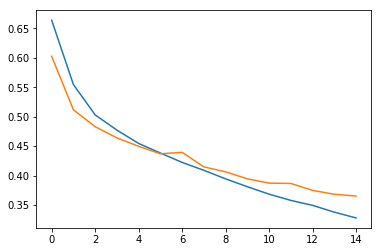

In [0]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

In [0]:
y_te_pred=model.predict_classes(X_test)
y_tr_pred=model.predict_classes(X_train)

In [0]:
from sklearn.metrics import accuracy_score,f1_score,precision_recall_fscore_support
print(accuracy_score(y_test,y_te_pred))
print(f1_score(y_test,y_te_pred))
precision_recall_fscore_support(y_test,y_te_pred)

0.8360369353631145
0.8187586206896552


(array([0.87155535, 0.79528403]),
 array([0.83007117, 0.84366117]),
 array([0.85030759, 0.81875862]),
 array([2248, 1759]))

In [0]:
print(accuracy_score(y_train,y_tr_pred))
print(f1_score(y_train,y_tr_pred))
precision_recall_fscore_support(y_train,y_tr_pred)

0.8762302096705178
0.8624093233440363


(array([0.90530491, 0.84217861]),
 array([0.87043569, 0.88363592]),
 array([0.88752795, 0.86240932]),
 array([10489,  8207]))